In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from vit_pytorch import ViT
from vit_pytorch.vit import Attention, repeat, Transformer, FeedForward
from einops import rearrange
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def DatasetLoader(dataset="MNIST", batch_size=128):
    if dataset=="MNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    elif dataset=="CIFAR10":
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
        test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # DataLoader for training and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [4]:
class AttentionForPruning(Attention):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__(dim=dim, heads=heads, dim_head=dim_head, dropout=dropout)
        
    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out), attn

class TransformerForPruning(Transformer):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__(dim=dim, depth=depth, heads=heads, dim_head=dim_head, mlp_dim=mlp_dim, dropout=dropout)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                AttentionForPruning(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            attn_x = attn(x)
            x = attn_x[0] + x
            x = ff(x) + x

        return self.norm(x), attn_x[1]

In [5]:
class CompressViT(ViT):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., comp_type=None, comp_ratio=0.25):
        super().__init__(image_size=image_size, patch_size=patch_size, num_classes=num_classes, dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim, pool=pool, channels=channels, dim_head=dim_head, dropout=dropout, emb_dropout=emb_dropout)
        
        # self.transformer = ATransformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        
        if comp_type=="mlp_comp":
            self.group_size = int(1//comp_ratio)
            self.compress = nn.Linear(self.group_size*dim, dim)
            
        elif comp_type=="kprune":
            self.transformer = TransformerForPruning(dim, depth, heads, dim_head, mlp_dim, dropout)
            # self.attn = TopKAttention(dim, heads = heads, dim_head = dim_head, dropout = dropout)
            self.comp_ratio = comp_ratio
        # self.mlp = nn.Linear(dim * int((image_size/patch_size)**2*comp_ratio), num_classes)
        
    def forward_with_compress(self, img, comp_type, return_tokens=False):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        
        if not comp_type == "kprune":
            x = self.transformer(x)
        
        # compressing img tokens
        cls_tokens = x[:, [0]]
        
        if comp_type == "mlp_comp":
            img_tokens = x[:, 1:]
            img_tokens = img_tokens.view(b, n//self.group_size, -1)
            img_tokens = self.compress(img_tokens)
            
        elif comp_type == "kprune":
            x, attn = self.transformer(x)
            attn = attn.sum(dim=1)
            attn = attn[:, 0, 1:]
            K=int(n*self.comp_ratio)
            _, top_k_indices = torch.topk(attn, K, dim=-1, largest=True, sorted=False)
            img_tokens = x.gather(1, top_k_indices.unsqueeze(-1).expand(-1, -1, x.shape[-1]))
        
        x = torch.cat((cls_tokens, img_tokens), dim=1)
        # end of compression
        
        if return_tokens:
            return img_tokens
        
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)

In [6]:
class ExtVit(nn.Module):
    def __init__(self, model="base", image_size=28, patch_size=7, num_classes=10, dim=64, depth=4, heads=8, mlp_dim=128, channels=1):
        super().__init__()
        self.model = model
        if model=="base":
            self.vit = ViT(
                image_size=image_size,          
                patch_size=patch_size,      
                num_classes=num_classes,
                dim=dim,
                depth=depth,
                heads=heads, 
                mlp_dim=mlp_dim, 
                channels=channels
            )
        else:
            self.vit = CompressViT(
                image_size=image_size,          
                patch_size=patch_size,      
                num_classes=num_classes,
                dim=dim,
                depth=depth,
                heads=heads, 
                mlp_dim=mlp_dim, 
                channels=channels,
                comp_type=model,
                pool='mean'
            )
        
    def forward(self, x, return_tokens=False):
        if self.model == "base":
            return self.vit(x)
        else:
            return self.vit.forward_with_compress(x, self.model, return_tokens)

In [7]:
class TokenClassifier(nn.Module):
    def __init__(self, image_size, patch_size, num_classes=10, dim=64, comp_ratio=0.25):
        super(TokenClassifier, self).__init__()
        self.mlp = nn.Linear(dim * int((image_size/patch_size)**2*comp_ratio), num_classes)

    def forward(self, img_tokens):
        x = img_tokens.view(img_tokens.size(0), -1)
        return self.mlp(x)

In [8]:
def train_model(model, token_model, train_loader, test_loader, epochs=1, token_epochs=1, padding=None):
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            if padding is not None:
                images = F.pad(images, padding)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
        losses.append(total_loss / len(train_loader))
    
    tokens_cache = []
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            if padding is not None:
                images = F.pad(images, padding)
            images, labels = images.to(device), labels.to(device)
            img_tokens = model(images, return_tokens=True)
            tokens_cache.append([img_tokens, labels])
            
    optimizer = torch.optim.Adam(token_model.parameters(), lr=0.001)
    for epoch in range(token_epochs):
        token_model.train()
        total_loss = 0
        for img_tokens, labels in tokens_cache:
            optimizer.zero_grad()
            outputs = token_model(img_tokens)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Token Model Epoch {epoch + 1}/{token_epochs}, Loss: {total_loss / len(train_loader):.4f}")
        losses.append(total_loss / len(train_loader))
        
    # Evaluate
    token_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if padding is not None:
                images = F.pad(images, padding)
            images, labels = images.to(device), labels.to(device)
            img_tokens = model(images, return_tokens=True)
            outputs = token_model(img_tokens)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    elapsed_time = time.time() - start_time
    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.2%}, Time Elapsed: {elapsed_time:.2f} seconds")
    return [test_acc, elapsed_time], losses

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [52]:
torch.manual_seed(20) #3
train_loader, test_loader = DatasetLoader("MNIST", batch_size=128)
models = ["base", "mlp_comp", "kprune"]
results, losses = [], []
for model_name in models[2:]:
    model = ExtVit(model_name, image_size=56, patch_size=4).to(device)
    token_model = TokenClassifier(image_size=56, patch_size=4).to(device)
    train_model(model, token_model, train_loader, test_loader, epochs=10, token_epochs=5, padding=(14, 14, 14, 14))
    # result, loss = train_model(model, token_model, train_loader, test_loader, epochs=10, token_epochs=5, padding=(14, 14, 14, 14))
    # result.append(count_parameters(model))
    # results.append(result)
    # losses.append(loss)

Epoch 1/10, Loss: 0.5635
Epoch 2/10, Loss: 0.1518
Epoch 3/10, Loss: 0.1121
Epoch 4/10, Loss: 0.0874
Epoch 5/10, Loss: 0.0738
Epoch 6/10, Loss: 0.0656
Epoch 7/10, Loss: 0.0589
Epoch 8/10, Loss: 0.0536
Epoch 9/10, Loss: 0.0453
Epoch 10/10, Loss: 0.0452
Token Model Epoch 1/10, Loss: 0.0423
Token Model Epoch 2/10, Loss: 0.0328
Token Model Epoch 3/10, Loss: 0.0267
Token Model Epoch 4/10, Loss: 0.0201
Token Model Epoch 5/10, Loss: 0.0167
Test Accuracy: 97.53%, Time Elapsed: 1284.36 seconds


In [10]:
torch.manual_seed(20) #3
train_loader, test_loader = DatasetLoader("MNIST", batch_size=128)
models = ["base", "mlp_comp", "kprune"]
results, losses = [], []
for model_name in models[1:]:
    model = ExtVit(model_name, image_size=56, patch_size=4).to(device)
    token_model = TokenClassifier(image_size=56, patch_size=4).to(device)
    result, loss = train_model(model, token_model, train_loader, test_loader, epochs=10, token_epochs=5, padding=(14, 14, 14, 14))
    result.append(count_parameters(model))
    results.append(result)
    losses.append(loss)

Epoch 1/10, Loss: 0.5560
Epoch 2/10, Loss: 0.1489
Epoch 3/10, Loss: 0.1056
Epoch 4/10, Loss: 0.0845
Epoch 5/10, Loss: 0.0718
Epoch 6/10, Loss: 0.0603
Epoch 7/10, Loss: 0.0557
Epoch 8/10, Loss: 0.0525
Epoch 9/10, Loss: 0.0462
Epoch 10/10, Loss: 0.0420
Token Model Epoch 1/5, Loss: 0.0774
Token Model Epoch 2/5, Loss: 0.0882
Token Model Epoch 3/5, Loss: 0.0934
Token Model Epoch 4/5, Loss: 0.0952
Token Model Epoch 5/5, Loss: 0.0959
Test Accuracy: 97.39%, Time Elapsed: 810.55 seconds
Epoch 1/10, Loss: 0.5219
Epoch 2/10, Loss: 0.1446
Epoch 3/10, Loss: 0.1017
Epoch 4/10, Loss: 0.0840
Epoch 5/10, Loss: 0.0684
Epoch 6/10, Loss: 0.0589
Epoch 7/10, Loss: 0.0556
Epoch 8/10, Loss: 0.0502
Epoch 9/10, Loss: 0.0430
Epoch 10/10, Loss: 0.0398
Token Model Epoch 1/5, Loss: 0.0414
Token Model Epoch 2/5, Loss: 0.0272
Token Model Epoch 3/5, Loss: 0.0207
Token Model Epoch 4/5, Loss: 0.0184
Token Model Epoch 5/5, Loss: 0.0156
Test Accuracy: 97.65%, Time Elapsed: 789.83 seconds


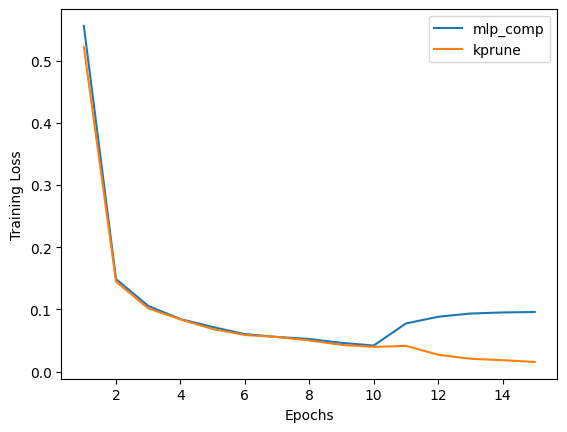

In [36]:
for loss, model in zip(losses, models[1:]):
    plt.plot(range(1, len(loss)+1), loss, label=model)
    plt.ylabel('Training Loss')
    plt.xlabel("Epochs")
    plt.legend()

In [37]:
df = pd.DataFrame(
    [(p, acc*100, t) for acc, t, p in results], 
    index=models[1:], 
    columns=["#Params", "Test Acc (%)", "Time (s)"]
)
print(df.round(2))

          #Params  Test Acc (%)  Time (s)
mlp_comp   623018         97.39    745.00
kprune     606570         97.65    766.01


In [ ]:
torch.manual_seed(20) #3
train_loader, test_loader = DatasetLoader("MNIST", batch_size=128)
models = ["base", "mlp_comp", "kprune"]
results, losses = [], []
for model_name in models[1:]:
    model = ExtVit(model_name, image_size=56, patch_size=4).to(device)
    token_model = TokenClassifier(image_size=56, patch_size=4).to(device)
    result, loss = train_model(model, token_model, train_loader, test_loader, epochs=10, token_epochs=5, padding=(14, 14, 14, 14))
    result.append(count_parameters(model))
    results.append(result)
    losses.append(loss)

In [51]:
torch.manual_seed(20)
train_loader, test_loader = DatasetLoader("CIFAR10", batch_size=64)
models = ["base", "mlp_comp", "kprune"]
results_c, losses_c = [], []
for model_name in models[1:]:
    model = ExtVit(model_name, image_size=64, patch_size=4, channels=3).to(device)
    token_model = TokenClassifier(image_size=64, patch_size=4).to(device)
    result, loss = train_model(model, token_model, train_loader, test_loader, epochs=30, token_epochs=15, padding=(16, 16, 16, 16))
    result.append(count_parameters(model))
    results_c.append(result)
    losses_c.append(loss)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30, Loss: 1.6769
Epoch 2/30, Loss: 1.3120
Epoch 3/30, Loss: 1.1843
Epoch 4/30, Loss: 1.0832
Epoch 5/30, Loss: 1.0018
Epoch 6/30, Loss: 0.9315
Epoch 7/30, Loss: 0.8604
Epoch 8/30, Loss: 0.7993
Epoch 9/30, Loss: 0.7422
Epoch 10/30, Loss: 0.6815
Epoch 11/30, Loss: 0.6264
Epoch 12/30, Loss: 0.5745
Epoch 13/30, Loss: 0.5301
Epoch 14/30, Loss: 0.4786
Epoch 15/30, Loss: 0.4437
Epoch 16/30, Loss: 0.4037
Epoch 17/30, Loss: 0.3659
Epoch 18/30, Loss: 0.3401
Epoch 19/30, Loss: 0.3162
Epoch 20/30, Loss: 0.2869
Epoch 21/30, Loss: 0.2766
Epoch 22/30, Loss: 0.2515
Epoch 23/30, Loss: 0.2385
Epoch 24/30, Loss: 0.2270
Epoch 25/30, Loss: 0.2172
Epoch 26/30, Loss: 0.2024
Epoch 27/30, Loss: 0.1949
Epoch 28/30, Loss: 0.1849
Epoch 29/30, Loss: 0.1812
Epoch 30/30, Loss: 0.1746
Token Model Epoch 1/30, Loss: 0.4215
Token Model Epoch 2/30, Loss: 0.4511
Token Model Epoch 3/30, Loss: 0.4231
Token Model Epoch 4/30, Loss: 0.4241
Token

In [47]:
# for loss, model in zip(losses_c, models):
#     plt.plot(range(1, len(loss)+1), loss, label=model)
#     plt.ylabel('Training Loss')
#     plt.xlabel("Epochs")
#     plt.legend()

In [48]:
# df = pd.DataFrame(
#     [(p, acc*100, t) for acc, t, p in results_c], 
#     index=models, 
#     columns=["#Params", "Test Acc (%)", "Time (s)"]
# )
# print(df.round(2))